<a href="https://colab.research.google.com/github/REICHIYAN/REI/blob/master/VolatilityMeanRevartion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  10  @  573.1168212890625 Position:  -10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
Sell  10  @  579.67724609375 Position:  -20
OpenPnL:  -65.604248046875  ClosedPnL:  0  TotalPnL:  -65.604248046875
OpenPnL:  -78.7548828125  ClosedPnL:  0  TotalPnL:  -78.7548828125
OpenPnL:  -29.73876953125  ClosedPnL:  0  TotalPnL:  -29.73876953125
Sell  10  @  559.816650390625 Position:  -30
OpenPnL:  331.607666015625  ClosedPnL:  0  TotalPnL:  331.607666015625
Buy  10  @  548.558837890625 Position:  -20
OpenPnL:  892.4560546875  ClosedPnL:  0  TotalP

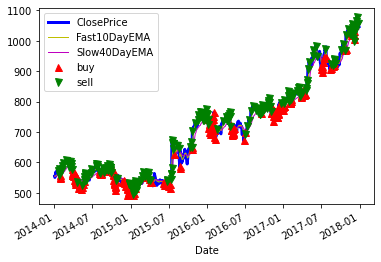

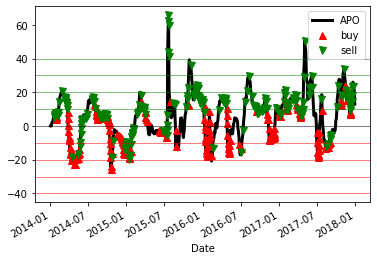

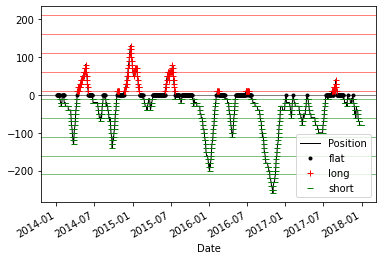

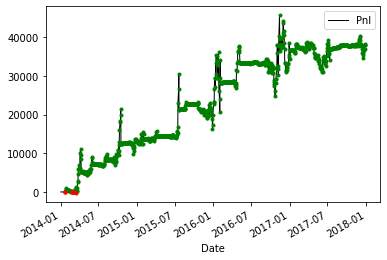

In [1]:
import pandas as pd
from pandas_datareader import data

# Fetch daily data for 4 years
SYMBOL='GOOG'
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME=SYMBOL + '_data.pkl'

try:
  data = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  data = data.DataReader(SYMBOL, 'yahoo', start_date, end_date)
  data.to_pickle(SRC_DATA_FILENAME)

# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -10 # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10 # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions and lock profits

import statistics as stats
import math as math

# Constants/variables that are used to compute standard deviation as a volatility measure
SMA_NUM_PERIODS = 20 # look back period
price_history = [] # history of prices

close=data['Close']
for close_price in close:
  price_history.append(close_price)
  if len(price_history) > SMA_NUM_PERIODS: # we track at most 'time_period' number of prices
    del (price_history[0])

  sma = stats.mean(price_history)
  variance = 0 # variance is square of standard deviation
  for hist_price in price_history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(price_history))
  stdev_factor = stdev/15
  if stdev_factor == 0:
    stdev_factor = 1

  # This section updates fast and slow EMA and computes APO trading signal
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST*stdev_factor + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW*stdev_factor + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

  # This section checks trading signal against trading parameters/thresholds and positions, to trade.

  # We will perform a sell trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
  if ((apo > APO_VALUE_FOR_SELL_ENTRY*stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO above sell entry threshold, we should sell
    or
    (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # long from -ve APO and APO has gone positive or position is profitable, sell to close position
    orders.append(-1) # mark the sell trade
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

  # We will perform a buy trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
  elif ((apo < APO_VALUE_FOR_BUY_ENTRY*stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO below buy entry threshold, we should buy
    or
    (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # short from +ve APO and APO has gone negative or position is profitable, buy to close position
    orders.append(+1) # mark the buy trade
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
  else:
    # No trade since none of the conditions were met to buy or sell
    orders.append(0)

  positions.append(position)

  # This section updates Open/Unrealized & Closed/Realized positions
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
  else:
    # flat, so update closed_pnl and reset tracking variables for positions & pnls
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
  pnls.append(closed_pnl + open_pnl)

# This section prepares the dataframe from the trading strategy results and visualizes the results
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

import matplotlib.pyplot as plt

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

data.to_csv("volatility_adjusted_mean_reversion.csv", sep=",")